In [1]:
import copy

import networkx
import shapely.geometry
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# We're in engineering cordinates (m)
coords = [
    [0, 0],
    [100000, 0],
    [200000, 0],
    [200000, 150000],
    [200000, 250000],
    [306066, 106066],
    [376777, 176777],
    [350000, 0],
    [450000, 0],
    [217678, -17678],
    [376777, -176777]
]

# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]
    
]

In [3]:
points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

nodes = [
    dict(
        geometry=point,
        x=point.x,
        y=point.y,
        node_i=node_i
    )
    for node_i, point
    in enumerate(points)
]

In [4]:
edges = []
depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 
widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]
for e in edge_indices:
    edge_geometry = shapely.geometry.LineString([points[e[0]], points[e[1]]])
    edge_properties = dict(
        depth = 12.5,
        width = 300,
        geometry=edge_geometry, 
        length= round(edge_geometry.length),
        e=tuple(e)
    )
    edges.append(edge_properties)

df_edges = pd.DataFrame(edges)
df_edges['depth'] = depths
df_edges['width'] = widths
df_edges

,depth,width,geometry,length,e
0,12.5,300,"LINESTRING (0 0, 100000 0)",100000,"(0, 1)"
1,6.0,150,"LINESTRING (100000 0, 200000 0)",100000,"(1, 2)"
2,6.0,150,"LINESTRING (200000 0, 200000 150000)",150000,"(2, 3)"
3,6.0,150,"LINESTRING (200000 150000, 200000 250000)",100000,"(3, 4)"
4,4.5,150,"LINESTRING (200000 0, 306066 106066)",150000,"(2, 5)"
5,6.0,150,"LINESTRING (306066 106066, 376777 176777)",100000,"(5, 6)"
6,2.5,150,"LINESTRING (200000 0, 350000 0)",150000,"(2, 7)"
7,6.0,150,"LINESTRING (350000 0, 450000 0)",100000,"(7, 8)"
8,2.5,150,"LINESTRING (200000 0, 217678 -17678)",25000,"(2, 9)"
9,6.0,150,"LINESTRING (217678 -17678, 376777 -176777)",225000,"(9, 10)"


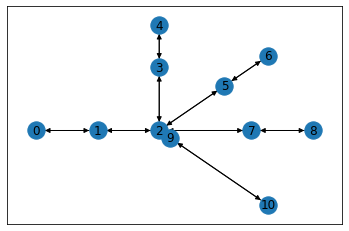

In [5]:
graph = nx.DiGraph()

for node in nodes:
    graph.add_node(node['node_i'], **node)
    
# Add up and downstream
for edge in edges:
    graph.add_edge(edge['e'][0], edge['e'][1], **edge)
    graph.add_edge(edge['e'][1], edge['e'][0], **edge)

pos = {
    node['node_i']: (node['x'], node['y']) 
    for node 
    in nodes
}

nx.draw_networkx(graph, pos=pos)


In [6]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

,rws_type,fuel,H2,Battery,E-LNG,E-Methanol
0,M8,3000,999000,3300,432000,165900


In [12]:
def split_edge(edge, distance=100):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    edges = {}
    # loop over the start, end point pairs
    edge_pairs = list(
        zip(
            points[:-1], 
            points[1:]
        )
    )
    for edge_i, (point_a, point_b) in enumerate(edge_pairs):    
        edge_geometry = shapely.geometry.LineString([point_a, point_b])
        node_a = edge_i
        node_b = edge_i + 1
        edges[(node_a, node_b)] = edge_geometry
    return points, edges

def split_and_replace_edge(graph, edge, distance=100):
    """remove edge from the network and replace it by points in between"""
    # Remember the edge to remove
    e_replace = edge['e']
    # determine the points that we want to intersect
    intersection_points, intersection_edges = split_edge(edge, distance=distance)
    # Try and remove the previous edges, if it fails, that's ok
    try:
        graph.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    # also remove the oposite edge direction
    try:
        graph.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # start at the start of our replaced edge
    nodes = [graph.nodes[e_replace[0]]]
    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            geometry=point,
            x=point.x,
            y=point.y,
            node_i=node_id
        )
        nodes.append(node_properties)
    # end at the end of our edge
    nodes.append(graph.nodes[e_replace[1]])

    # add all the node properties, skip first and last, because they already exist
    for node in nodes[1:-1]:
        node_i = node['node_i']
        pos[node_i] = [node['x'], node['y']]
        # add the nodes in between
        graph.add_node(node_i, **node)
        
    # now loop over all the node pairs in between our edge
    edges = []
    for node_a, node_b in zip(nodes[:-1], nodes[1:]):
        # this is our new edge
        e = (node_a['node_i'], node_b['node_i'])
        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            node_a['geometry'], 
            node_b['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            depth= 12.5, 
            width= 300, 
            geometry=edge_geometry, 
            length=edge_geometry.length,
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        graph.add_edge(e[0], e[1], **edge)
        graph.add_edge(e[1], e[0], **edge)
    
    return edges

In [15]:

split_edge_0 = split_and_replace_edge(graph, edges[0], distance=1000)
split_edge_1 = split_and_replace_edge(graph, edges[1], distance=1000)
split_edge_2 = split_and_replace_edge(graph, edges[2], distance=1000)
split_edge_3 = split_and_replace_edge(graph, edges[3], distance=1000)
split_edge_4 = split_and_replace_edge(graph, edges[4], distance=1000)
split_edge_5 = split_and_replace_edge(graph, edges[5], distance=1000)
split_edge_6 = split_and_replace_edge(graph, edges[6], distance=1000)
split_edge_7 = split_and_replace_edge(graph, edges[7], distance=1000)
split_edge_8 = split_and_replace_edge(graph, edges[8], distance=1000)
split_edge_9 = split_and_replace_edge(graph, edges[9], distance=1000)


df_split_edge_0 = pd.DataFrame(split_edge_0)

df_split_edge_1 = pd.DataFrame(split_edge_1)
df_split_edge_2 = pd.DataFrame(split_edge_2)
df_split_edge_3 = pd.DataFrame(split_edge_3)
df_split_edge_4 = pd.DataFrame(split_edge_4)
df_split_edge_5 = pd.DataFrame(split_edge_5)
df_split_edge_6 = pd.DataFrame(split_edge_6)
df_split_edge_7 = pd.DataFrame(split_edge_7)
df_split_edge_8 = pd.DataFrame(split_edge_8)
df_split_edge_9 = pd.DataFrame(split_edge_9)

# to do replace depth width for df, https://www.delftstack.com/howto/python-pandas/pandas-replace-values-in-column/
# assign df to the Graph info

In [20]:
df_path_deep =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_2).append(df_split_edge_3)
df_path_shallow =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_4).append(df_split_edge_5)
df_path_limiting =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_6).append(df_split_edge_7)
df_path_short_lim =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_8).append(df_split_edge_9)

df_path_deep.tail(200)

C:\Users\manjiang\AppData\Local\Temp\ipykernel_14536\2782100999.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_path_deep =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_2).append(df_split_edge_3)
C:\Users\manjiang\AppData\Local\Temp\ipykernel_14536\2782100999.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_path_deep =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_2).append(df_split_edge_3)
C:\Users\manjiang\AppData\Local\Temp\ipykernel_14536\2782100999.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_path_shallow =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_4).append(df_split_edge_5)
C:\Users\manjiang\AppData\Local\Temp\ipykernel_14536\2782100999.py:2: 

,depth,width,geometry,length,e
50,12.5,300,"LINESTRING (200000 50000, 200000 51000.0000000...",1000.0,"(2-49-3, 2-50-3)"
51,12.5,300,"LINESTRING (200000 51000.00000000001, 200000 5...",1000.0,"(2-50-3, 2-51-3)"
52,12.5,300,"LINESTRING (200000 52000, 200000 53000)",1000.0,"(2-51-3, 2-52-3)"
53,12.5,300,"LINESTRING (200000 53000, 200000 54000)",1000.0,"(2-52-3, 2-53-3)"
54,12.5,300,"LINESTRING (200000 54000, 200000 54999.9999999...",1000.0,"(2-53-3, 2-54-3)"
...,...,...,...,...,...
95,12.5,300,"LINESTRING (200000 245000, 200000 246000)",1000.0,"(3-94-4, 3-95-4)"
96,12.5,300,"LINESTRING (200000 246000, 200000 247000)",1000.0,"(3-95-4, 3-96-4)"
97,12.5,300,"LINESTRING (200000 247000, 200000 248000)",1000.0,"(3-96-4, 3-97-4)"
98,12.5,300,"LINESTRING (200000 248000, 200000 249000)",1000.0,"(3-97-4, 3-98-4)"


In [11]:
df_split_edges = pd.DataFrame(edges[9])
# df_split_edges['depth'] = depths
# df_split_edges['width'] = widths
df_split_edges

,depth,width,geometry,length,e
0,12.5,300,"LINESTRING (217678 -17678, 376777 -176777)",225000,9
1,12.5,300,"LINESTRING (217678 -17678, 376777 -176777)",225000,10


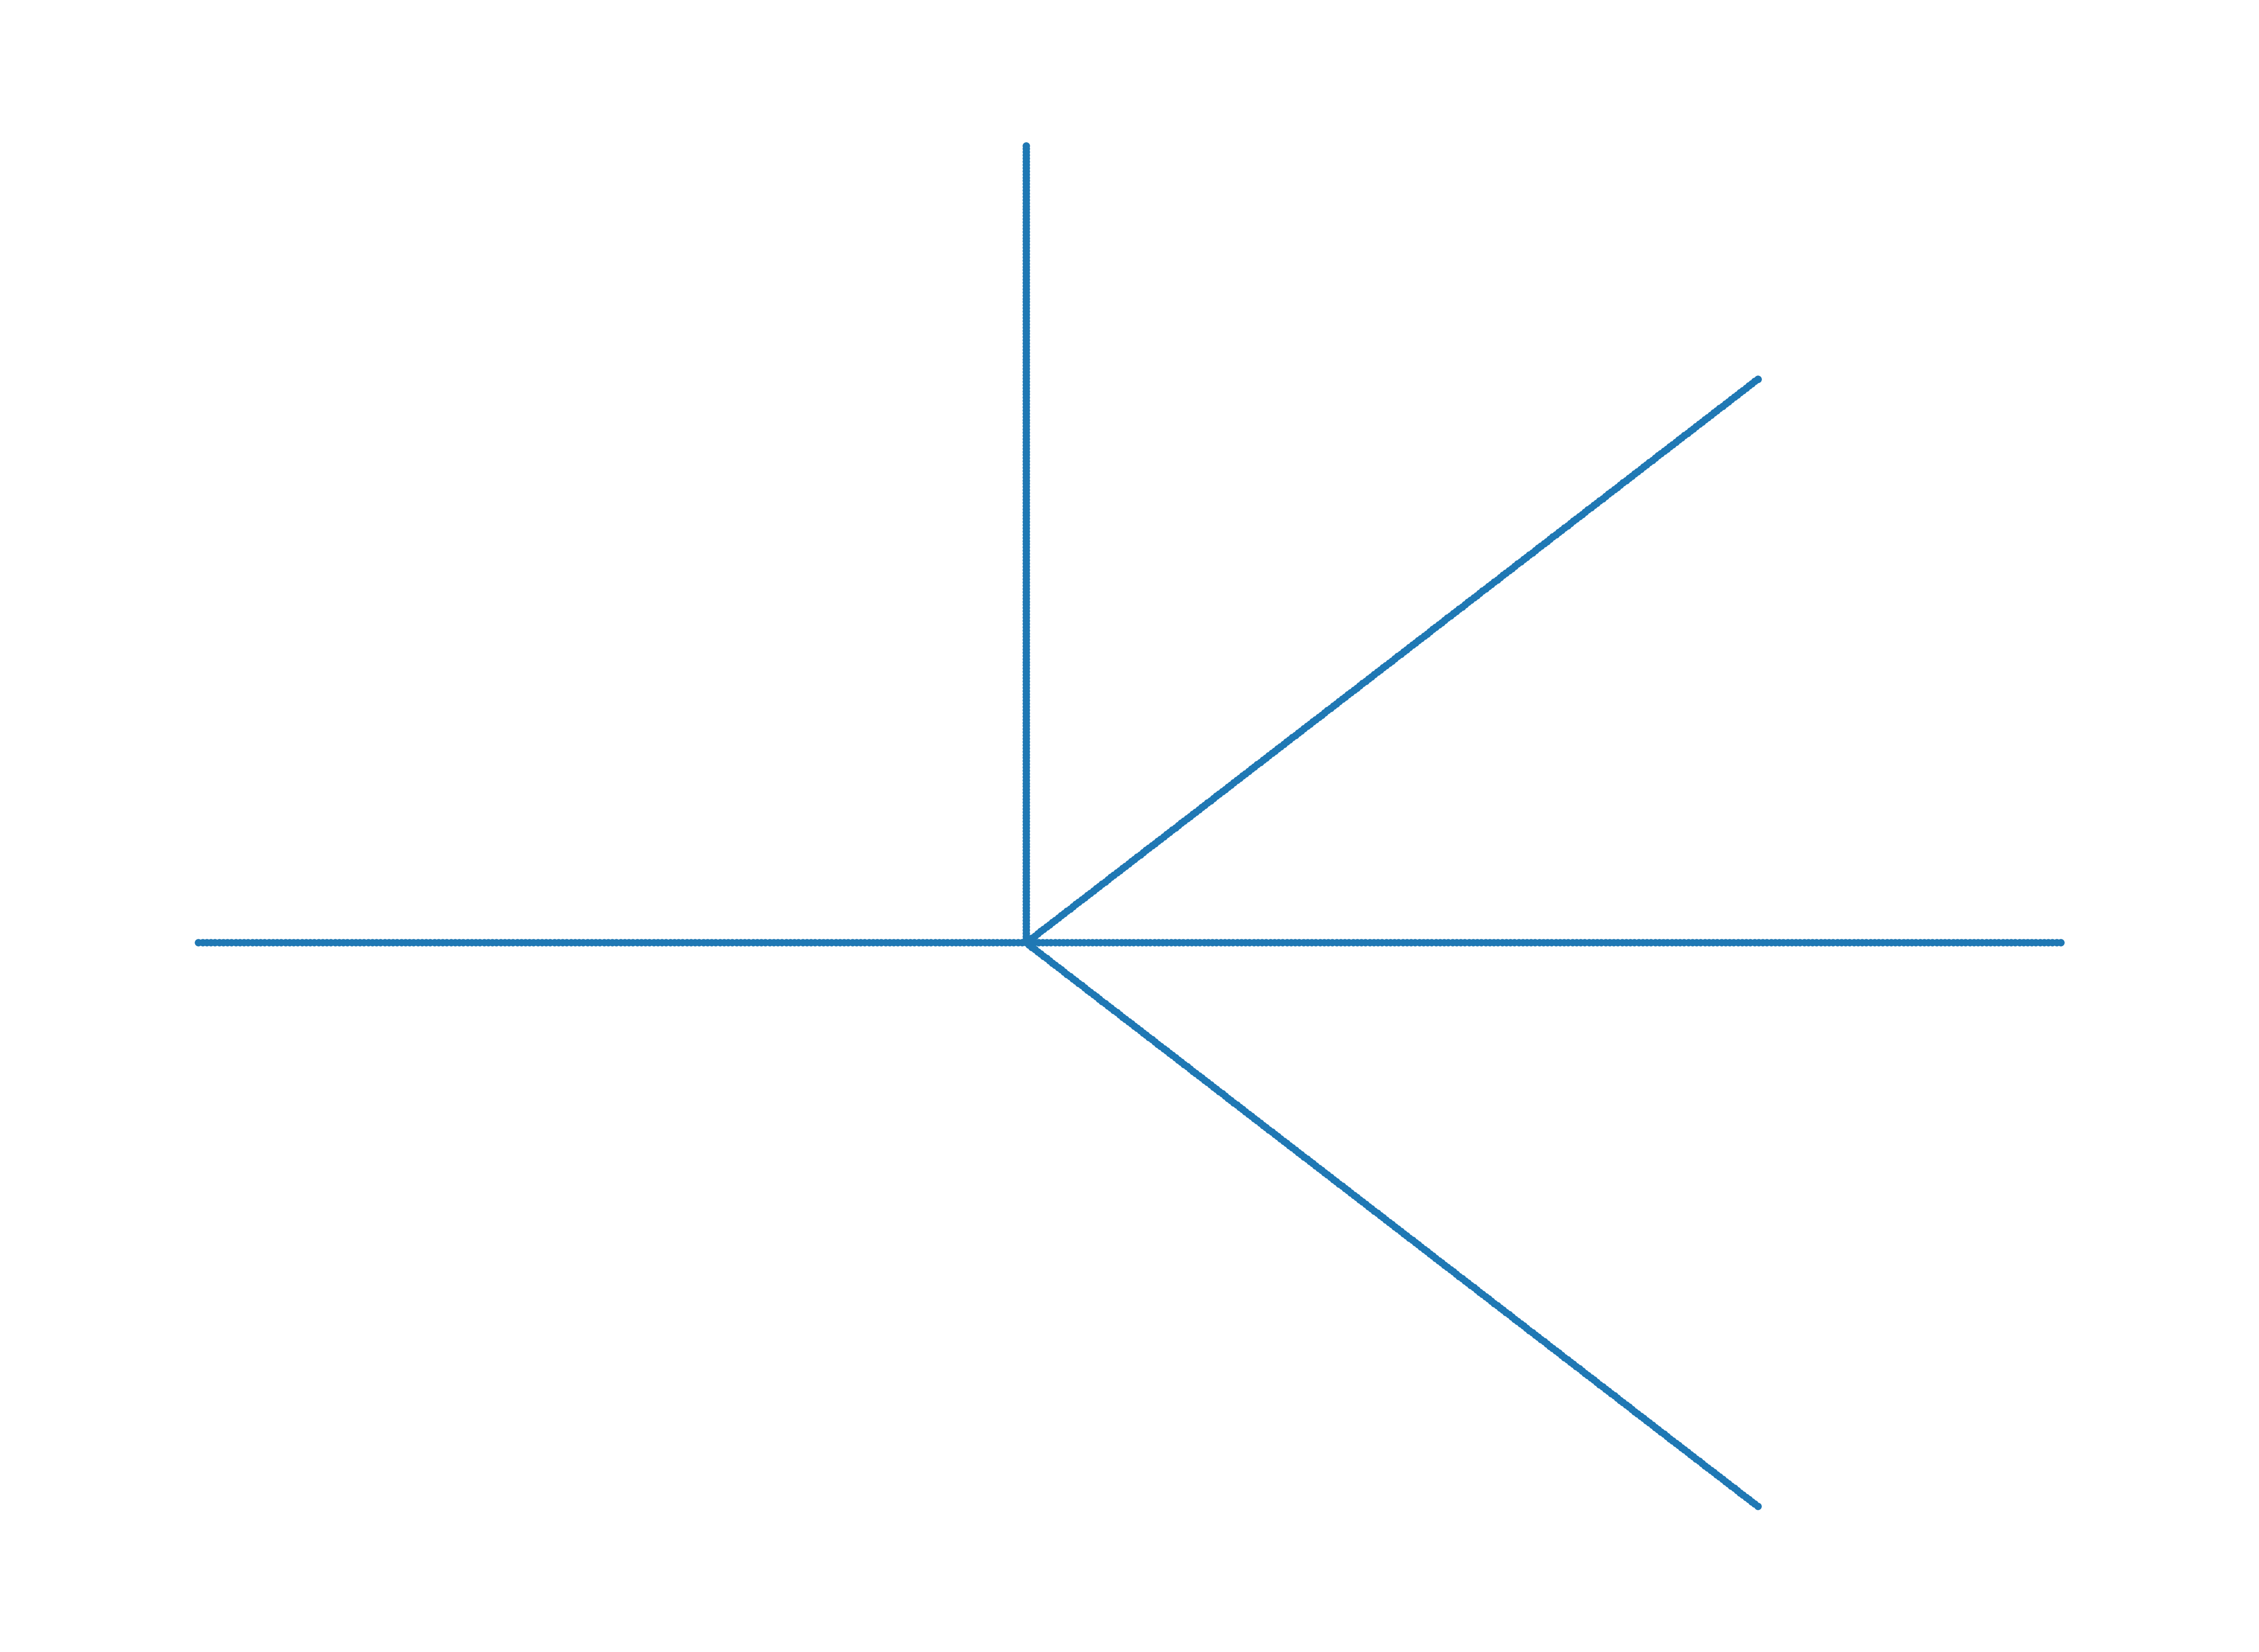

In [10]:
fig, ax = plt.subplots(figsize=(100, 75))
# nx.draw_networkx(graph, pos=pos, ax=ax)
nx.draw(graph, pos=pos, ax=ax)
plt.savefig('network.pdf', bbox_inches = 'tight', dpi=600, format='pdf')  